# Plot zonal annual mean NOy

---

Create date: 2025-08-19

Plot zonal mean of NOy from Ozone investigation [Ticket link](https://code.metoffice.gov.uk/trac/UKESM/wiki/1016_Simulations)


In [77]:
import yaml
import iris
import xarray as xr
from ncdata.iris_xarray import cubes_to_xarray
import sys
import matplotlib.pyplot as plt

# local module
sys.path.append("/home/users/vs480/ukesm-eval-python")
sys.path.append("/home/users/vs480/explore_cmip6")
from informal.vs480.STASH_fields_defs import UKCA_callback
import src.const as CONST

In [12]:
# Load config
with open("config.yaml") as f:
    config = yaml.safe_load(f)

In [ ]:
def pp_paths(data_root_dir: str, dataset_suites: dict[str, str], stashes: list[str]):
    """
    Create dictionary of lists of file paths for each suite.

    Parameters
    ----------
    data_root_dir : str
        Root directory where data is stored.
    dataset_suites : dict of str
        Mapping of dataset names to Rose suite IDs. e.g. u-ab123
    stashes : list of str
        List of stash items. e.g. 50001

    Returns
    -------
    dict of str to list of str
        Dictionary mapping dataset names to lists of file paths.

    """
    paths = {}
    for exp, suite in dataset_suites.items():
        paths[exp] = [f"{data_root_dir}/{suite}_apy.pp_{v}/*.pp" for v in stashes]
    return paths

In [ ]:
def load_xr_from_pp(
    paths: list[str],
    l_rename_coords: bool = False,
    rename_dict: dict = None,
):
    """
    Load a list of PP files into an xarray.Dataset .

    Parameters
    ----------
    paths : list of str
        List of file paths to load. May contain wildcard (*)
    l_rename_coords : bool, optional
        If True, rename coordinates using `rename_dict`. Default is False.
    rename_dict : dict, optional
        Dictionary mapping original coordinate names to new names. If None and renaming is requested,
        a default mapping for 'latitude', 'longitude', and 'model_level_number' is used.

    Returns
    -------
    xarray.Dataset
        The loaded dataset with coordinates optionally renamed.
    """

    # Check if paths is set
    if not paths:
        raise FileNotFoundError("No file paths provided to load_xr_from_pp.")

    # ensure dataset-level and variable-level attributes loaded correctly
    iris.FUTURE.save_split_attrs = True

    iris_cube = iris.load(paths, callback=UKCA_callback)

    ds = cubes_to_xarray(iris_cube)
    if l_rename_coords:
        if rename_dict is None:
            rename_dict = {
                "latitude": "lat",
                "longitude": "lon",
                "model_level_number": "lev",
            }

        ds = ds.rename(rename_dict)

    return ds


def load_multiple_exps(
    config: dict, exp_subset: list[str] = None, stashes_subset: list[str] = None
):
    """
    Load multiple experiments' datasets as xarray objects based on configuration and optional subsets.

    Parameters
    ----------
    config : dict
        Configuration dictionary containing 'dataset_suites', 'stashes', and 'pp_root_dir'.
    exp_subset : list of str, optional
        List of experiment keys to load. If None, all experiments in config['dataset_suites'] are loaded.
    stashes_subset : list of str, optional
        List of stash codes to load. If None, all stashes in config['stashes'] are loaded.

    Returns
    -------
    dict of str to xarray.Dataset
        Dictionary mapping experiment names to loaded xarray datasets.
    """

    if exp_subset is None:
        datasets_load = config["dataset_suites"]
    else:
        datasets_load = {
            e: config["dataset_suites"][e]
            for e in exp_subset
            if e in config["dataset_suites"]
        }

    if stashes_subset is None:
        stashes_load = config["stashes"]
    else:
        stashes_load = stashes_subset

    dataset_paths = pp_paths(
        data_root_dir=config["pp_root_dir"],
        dataset_suites=datasets_load,
        stashes=stashes_load,
    )

    datasets = {exp: load_xr_from_pp(paths) for exp, paths in dataset_paths.items()}

    return datasets

## Load data


In [ ]:
# Subset of values to load
exp_subset = [
    "e1-st2-hc",
    "e2-st2-hc",
    "e2-st2+lnox4-hc",
    "e2-st2+ipl7-hc",
    "e2-st2+ipl8-hc",
]

stashes_subset = ["34002", "34996", "34003", "50062"]

datasets = load_multiple_exps(config, exp_subset, stashes_subset)

/home/users/vs480/.conda/envs/cmip6-env/lib/python3.9/site-packages/iris/fileformats/rules.py:338: IrisUserWarning: Unable to create instance of HybridHeightFactory. The source data contains no field(s) for 'orography'.
  warnings.warn(
/home/users/vs480/.conda/envs/cmip6-env/lib/python3.9/site-packages/iris/fileformats/rules.py:338: IrisUserWarning: Unable to create instance of HybridHeightFactory. The source data contains no field(s) for 'orography'.
  warnings.warn(
/home/users/vs480/.conda/envs/cmip6-env/lib/python3.9/site-packages/iris/fileformats/rules.py:338: IrisUserWarning: Unable to create instance of HybridHeightFactory. The source data contains no field(s) for 'orography'.
  warnings.warn(
/home/users/vs480/.conda/envs/cmip6-env/lib/python3.9/site-packages/iris/fileformats/rules.py:338: IrisUserWarning: Unable to create instance of HybridHeightFactory. The source data contains no field(s) for 'orography'.
  warnings.warn(
/home/users/vs480/.conda/envs/cmip6-env/lib/python3.

## Plot NO


In [72]:
def def_custom_subplots(
    fig_width, widths_subplot, heights_subplot, exclude_last_row: bool = False
):

    fig = plt.figure(figsize=(fig_width, 0.5 * fig_width))

    nrow = len(heights_subplot)
    ncol = len(widths_subplot)

    gs = fig.add_gridspec(
        nrow, ncol, width_ratios=widths_subplot, height_ratios=heights_subplot
    )

    if exclude_last_row:
        nrow = nrow - 1

    axs = [fig.add_subplot(gs[i, j]) for i in range(nrow) for j in range(ncol)]

    return fig, axs, gs, nrow, ncol

In [124]:
zonal_mean_ppb = {e: xr.Dataset() for e in datasets.keys()}

molar_masses = {"no": CONST.M_NO, "no2": CONST.M_NO2, "no3": CONST.M_NO3}

for exp in zonal_mean_ppb.keys():
    for species in ["no", "no2", "no3"]:
        zonal_mean_ppb[exp][species] = (
            datasets[exp][species]
            .sel(time=slice("1865-01-01", "1895-01-01"))  # after spin-up
            .mean(
                dim=["lon", "time"],
            )
            .load()
            / molar_masses[species]
            * CONST.M_AIR
            * 1e9
        )

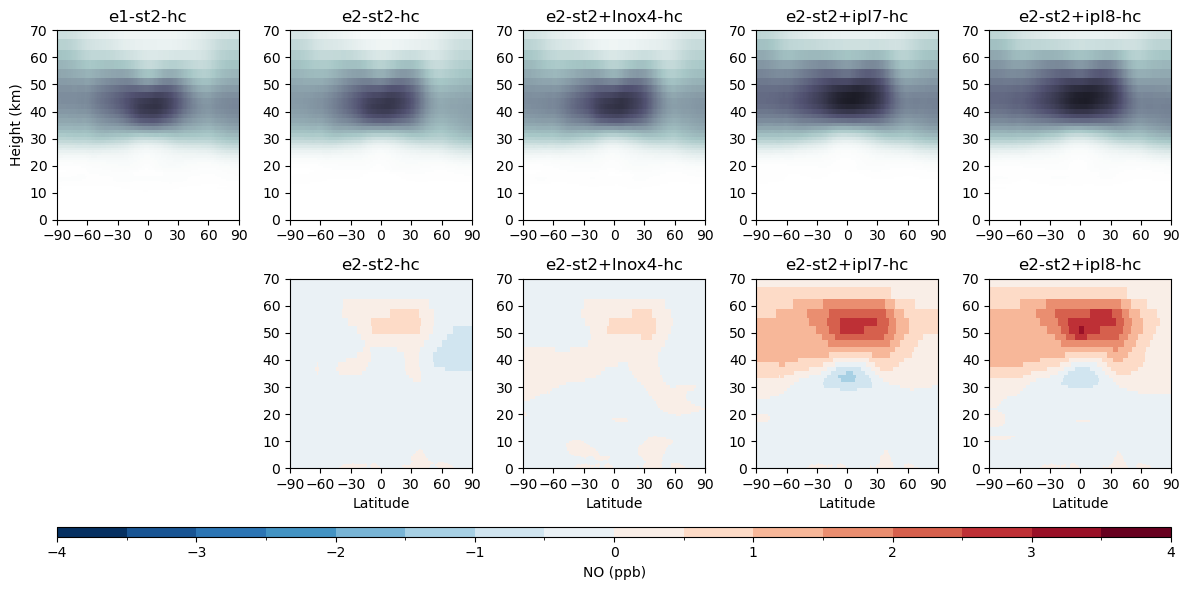

In [ ]:
fig, axs, gs, nrow, ncol = def_custom_subplots(
    fig_width=12,
    widths_subplot=[1, 1, 1, 1, 1],
    heights_subplot=[1, 1, 0.05],
    exclude_last_row=True,
)

species = "no"

for i, exp in enumerate(zonal_mean_ppb.keys()):
    ax = axs[i]
    d_plot = zonal_mean_ppb[exp][species]
    heatmap = d_plot.plot(
        ax=ax,
        x="lat",
        y="level_height",
        add_colorbar=False,
        vmax=10,
        vmin=0,
        cmap=plt.cm.bone_r,
    )

    ax.set_title(exp)

for i, exp in enumerate(zonal_mean_ppb.keys()):
    ax = axs[i + 5]
    d_plot = zonal_mean_ppb[exp][species] - zonal_mean_ppb["e1-st2-hc"][species]
    heatmap = d_plot.plot(
        ax=ax,
        x="lat",
        y="level_height",
        add_colorbar=False,
        vmax=4,
        vmin=-4,
        cmap=plt.cm.RdBu_r,
        levels=17,
    )

    ax.set_title(exp)

for ax in axs:
    ax.set_ylim(0, 70000)
    ax.set_yticks(range(0, 70001, 10000))
    yticks = ax.get_yticks()
    ax.set_yticklabels([f"{int(y/1000)}" for y in yticks])
    ax.set_ylabel("")
    ax.set_xticks(range(-90, 91, 30))
    ax.set_xlabel("")

for ax in axs[ncol:]:
    ax.set_xlabel("Latitude")

for ax in axs[::ncol]:
    ax.set_ylabel("Height (km)")

clb_ax = fig.add_subplot(gs[-1, :])
clb = fig.colorbar(
    heatmap,
    cax=clb_ax,
    extend="neither",
    orientation="horizontal",
    label=f"{species.upper()} (ppb)",
)
# clb.ax.set_xlabel(f"Aerosol mass loading" + " [$\mu$g m$^{-2}$]")

axs[5].remove()

fig.tight_layout()

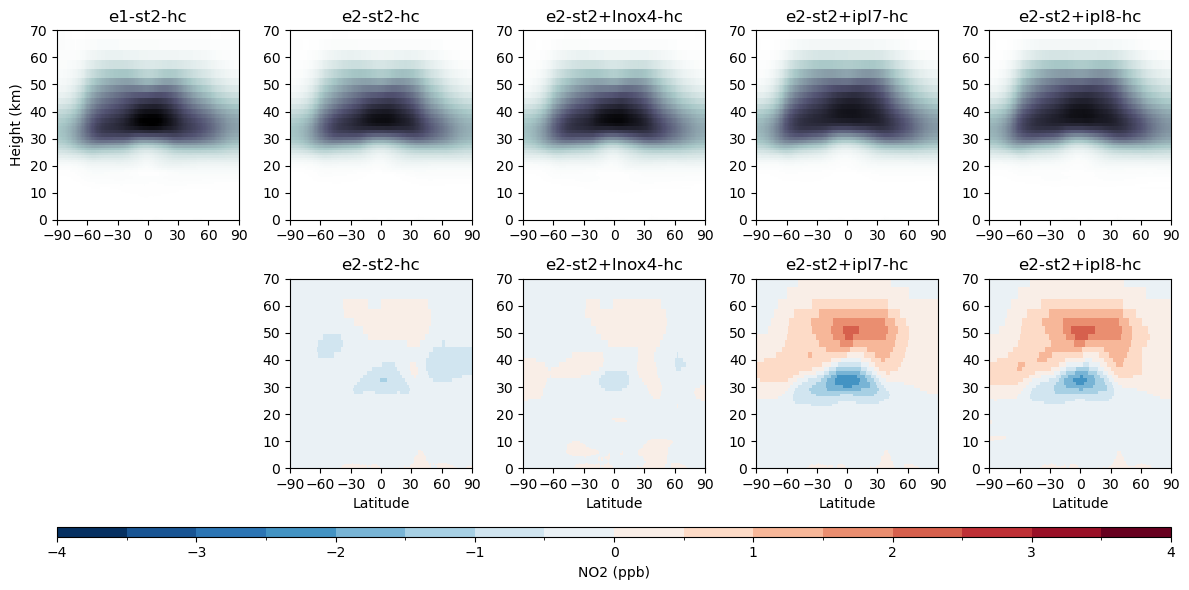

In [130]:
fig, axs, gs, nrow, ncol = def_custom_subplots(
    fig_width=12,
    widths_subplot=[1, 1, 1, 1, 1],
    heights_subplot=[1, 1, 0.05],
    exclude_last_row=True,
)

species = "no2"

for i, exp in enumerate(zonal_mean_ppb.keys()):
    ax = axs[i]
    d_plot = zonal_mean_ppb[exp][species]
    heatmap = d_plot.plot(
        ax=ax,
        x="lat",
        y="level_height",
        add_colorbar=False,
        vmax=10,
        vmin=0,
        cmap=plt.cm.bone_r,
    )

    ax.set_title(exp)

for i, exp in enumerate(zonal_mean_ppb.keys()):
    ax = axs[i + 5]
    d_plot = zonal_mean_ppb[exp][species] - zonal_mean_ppb["e1-st2-hc"][species]
    heatmap = d_plot.plot(
        ax=ax,
        x="lat",
        y="level_height",
        add_colorbar=False,
        vmax=4,
        vmin=-4,
        cmap=plt.cm.RdBu_r,
        levels=17,
    )

    ax.set_title(exp)

for ax in axs:
    ax.set_ylim(0, 70000)
    ax.set_yticks(range(0, 70001, 10000))
    yticks = ax.get_yticks()
    ax.set_yticklabels([f"{int(y/1000)}" for y in yticks])
    ax.set_ylabel("")
    ax.set_xticks(range(-90, 91, 30))
    ax.set_xlabel("")

for ax in axs[ncol:]:
    ax.set_xlabel("Latitude")

for ax in axs[::ncol]:
    ax.set_ylabel("Height (km)")

clb_ax = fig.add_subplot(gs[-1, :])
clb = fig.colorbar(
    heatmap,
    cax=clb_ax,
    extend="neither",
    orientation="horizontal",
    label=f"{species.upper()} (ppb)",
)
# clb.ax.set_xlabel(f"Aerosol mass loading" + " [$\mu$g m$^{-2}$]")

axs[5].remove()

fig.tight_layout()

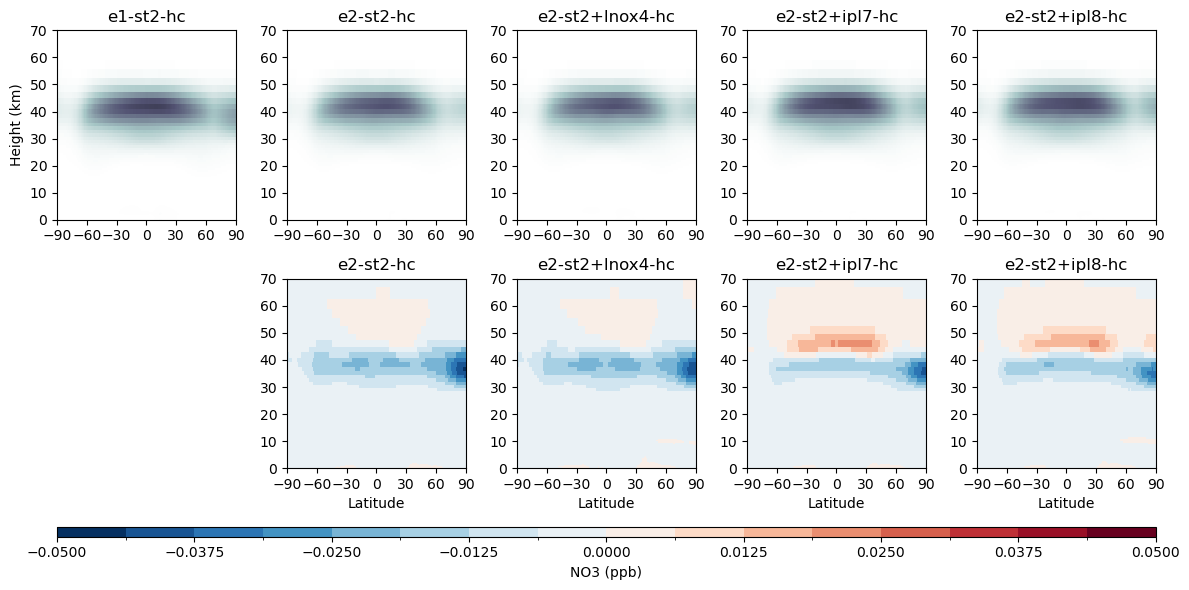

In [140]:
fig, axs, gs, nrow, ncol = def_custom_subplots(
    fig_width=12,
    widths_subplot=[1, 1, 1, 1, 1],
    heights_subplot=[1, 1, 0.05],
    exclude_last_row=True,
)

species = "no3"

for i, exp in enumerate(zonal_mean_ppb.keys()):
    ax = axs[i]
    d_plot = zonal_mean_ppb[exp][species]
    heatmap = d_plot.plot(
        ax=ax,
        x="lat",
        y="level_height",
        add_colorbar=False,
        vmax=0.2,
        vmin=0,
        cmap=plt.cm.bone_r,
    )

    ax.set_title(exp)

for i, exp in enumerate(zonal_mean_ppb.keys()):
    ax = axs[i + 5]
    d_plot = zonal_mean_ppb[exp][species] - zonal_mean_ppb["e1-st2-hc"][species]
    heatmap = d_plot.plot(
        ax=ax,
        x="lat",
        y="level_height",
        add_colorbar=False,
        vmax=0.05,
        vmin=-0.05,
        cmap=plt.cm.RdBu_r,
        levels=17,
    )

    ax.set_title(exp)

for ax in axs:
    ax.set_ylim(0, 70000)
    ax.set_yticks(range(0, 70001, 10000))
    yticks = ax.get_yticks()
    ax.set_yticklabels([f"{int(y/1000)}" for y in yticks])
    ax.set_ylabel("")
    ax.set_xticks(range(-90, 91, 30))
    ax.set_xlabel("")

for ax in axs[ncol:]:
    ax.set_xlabel("Latitude")

for ax in axs[::ncol]:
    ax.set_ylabel("Height (km)")

clb_ax = fig.add_subplot(gs[-1, :])
clb = fig.colorbar(
    heatmap,
    cax=clb_ax,
    extend="neither",
    orientation="horizontal",
    label=f"{species.upper()} (ppb)",
)
# clb.ax.set_xlabel(f"Aerosol mass loading" + " [$\mu$g m$^{-2}$]")

axs[5].remove()

fig.tight_layout()